# Classification of events tex

- text classification, logistic regression, stochastic gradient descent
- confusion matrix, precision, recall, ROC curve
- S&P Key Developments, Wharton Research Data Services

Terence Lim

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series
from wordcloud import WordCloud, STOPWORDS
from finds.database import MongoDB
from finds.unstructured import Unstructured
from finds.structured import PSTAT
from settings import settings
mongodb = MongoDB(**settings['mongodb'])
keydev = Unstructured(mongodb, 'KeyDev')
imgdir = os.path.join(settings['images'], 'keydev')
event_ = PSTAT.event_

## Construct corpus: to lower case, strip numeric

In [2]:
corpus = {}
events = [26, 27] #[16, 83]
for event in events:
    docs = keydev['events'].find(
        {'keydeveventtypeid': {'$eq': event}}, {'_id': 0})
    corpus[event] = [re.sub(r'\b\w*[\d]\w*\b', ' ', " ".join(
            d[k] for k in ['headline', 'situation'])).lower() for d in docs]
DataFrame({'description': [event_[event] for event in corpus.keys()],
           'count': [len(lines) for lines in corpus.values()]},
          index=corpus.keys())

,description,count
26,Corporate Guidance - Lowered,1557
27,Corporate Guidance - Raised,2890


## Tokenize, and remove stopwords

In [3]:
stop_words = STOPWORDS.union(['co', 'ltd', 'mr', 'mrs', 'inc', 'llc'])
for event, lines in corpus.items():
    corpus[event] = [[w for w in re.findall(r"\w\w+", line)
                      if w not in stop_words] for line in lines]
    


## Split shuffled into labelled training and test sets


In [4]:
train_data = []
test_data = []
split_frac = 0.9
for label, (event, lines) in enumerate(corpus.items()):
    np.random.shuffle(lines)
    n = int(split_frac * len(lines))   # split point of train and test sets
    train_data.extend([(label, corpus[event][p]) for p in range(n)])
    test_data.extend([(label, corpus[event][p]) for p in range(n, len(lines))])
N = len(train_data)
print('train/test:', N, [np.mean([label for label,_ in subset])
                         for subset in [train_data, test_data]])

train/test: 4002 [0.6499250374812594, 0.6494382022471911]


## Construct vocab from training set, and map words to indexes

In [5]:
from collections import Counter
words = Counter()
for label, line in train_data:
    words.update(set(line))
words = Series(words).sort_values(ascending=False)
words = ['_PAD_', '_UNK_'] + words[words > 2].index.to_list()
word2idx = {w: i for i,w in enumerate(words)}
idx2word = {i: w for i,w in enumerate(words)}
W = len(words)
print('vocab:', W, words[:20])

vocab: 3014 ['_PAD_', '_UNK_', 'guidance', 'company', 'year', 'earnings', 'million', 'revises', 'net', 'per', 'share', 'expects', 'quarter', 'revised', 'income', 'operating', 'ended', 'compared', 'revenue', 'results']


## Logistic Regression by SGD, with one-hot input vectors

- p = 1/(1 + np.exp(-w @ f)) = logistic(-w @ f) = inverse-logit
- logit = log(p / (1-p)) = logodds = "canonical link function for bernoulli"

MLE cannot be solved analytically, so numerically with gradient SGD

sigmoid can be other S-curve: e.g. logistic(), tanh(), arctan(), erf()

In [6]:
def one_hot(word2idx, words):
    """helper to form one-hot vectors from words and indexer"""
    f = np.zeros(len(word2idx) + 1)  # initialize weights vector including bias
    f[[word2idx[w] for w in words if w in word2idx]] = 1 # set each word index
    f[-1] = 1                        # and set bias term too
    return f
    
np.random.seed(0)
out = {'nll': [], 'acc': [], 'test': []} # track accuracy and log likelihood 
T = 15                      # max epochs
constant = False            # whether constant or step learning rate
w = np.random.randn(W+1)    # initialize vector for weights and bias
for epoch in range(T):
    permutation = np.random.permutation(len(train_data))
    out['acc'].append(0)
    out['nll'].append(0)    # negative log likelihood (to minimize)
    for i in permutation:
        f = one_hot(word2idx, train_data[i][1])   # one-hot representation
        p = 1/(1 + np.exp(-w @ f))                # predicted probability
        y = train_data[i][0]                      # true label
        out['acc'][-1] += (y == (p > 0.5)) / len(train_data)
        out['nll'][-1] -= (y * (-100 if p==0 else np.log(p)) +
                           (1-y) * (-100 if p==1 else np.log(1-p)))
        w = w + ((y - p) * f / (1 if constant else epoch + 1))
    out['test'].append(0)
    for i in range(len(test_data)):
        y = test_data[i][0]         # gold label
        f = one_hot(word2idx, test_data[i][1])
        p = 1/(1 + np.exp(-w @ f))  # predicted prob: let label be p>0.5
        out['test'][-1] += (y == (p > 0.5)) / len(test_data) # test set accuracy
DataFrame(out).round(3)



,nll,acc,test
0,25800.589,0.653,0.613
1,11020.615,0.745,0.726
2,5588.794,0.787,0.685
3,3569.502,0.815,0.726
4,2777.546,0.833,0.708
5,2276.652,0.845,0.708
6,1796.741,0.863,0.712
7,1629.816,0.869,0.717
8,1407.909,0.879,0.690
9,1254.022,0.888,0.703


## Plot train and test accuracy

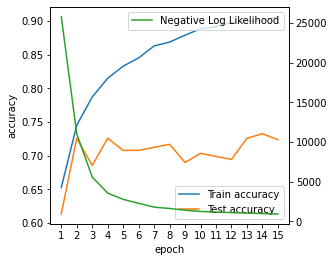

In [7]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(5,4))
ax.plot(np.arange(1, T+1).astype(str), out['acc'], color='C0')
ax.plot(np.arange(1, T+1).astype(str), out['test'], color='C1')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend(['Train accuracy', 'Test accuracy'])
bx = ax.twinx()
bx.plot(np.arange(1, T+1).astype(str), out['nll'], color='C2')
bx.legend(['Negative Log Likelihood'])
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'accuracy.jpg'))
    


## Compute predicted probs in test set

In [9]:
y, yproba = [], []
for i in range(len(test_data)):
    f = one_hot(word2idx, test_data[i][1])
    yproba.append(1/(1 + np.exp(-w @ f)))   # predicted proba
    y.append(test_data[i][0])

# Plot AUC and ROC curve in test set

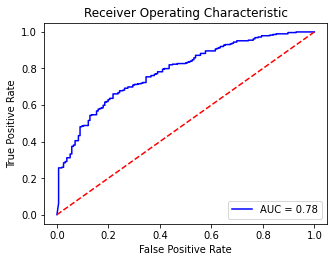

In [10]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y, yproba)
roc_auc = metrics.auc(fpr, tpr)
fig, ax = plt.subplots(num=2, clear=True, figsize=(5,4))
ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('Receiver Operating Characteristic')
plt.tight_layout(pad=2)
plt.savefig(os.path.join(imgdir, 'roc.jpg'))
plt.show()



## Evaluate confusion matrix: precision, recall, F1 in test set

In [12]:
n = len(y)
ypred = np.array(yproba) > 0.5
tn, fp, fn, tp = metrics.confusion_matrix(y, ypred).ravel()
accuracy = (tp + tn) / n     # predicted matches actual
precision = tp / (tp + fp)   # denom is number of predicted positives
recall = tp / (tp + fn)      # denom is number of positives in gold labels
f1 = 2 * precision * recall / (precision + recall)  # harmonic mean
assert(np.allclose([accuracy, precision, recall],   # sanity check
                   [metrics.accuracy_score(y, ypred),
                    metrics.precision_score(y, ypred, average='binary'),
                    metrics.recall_score(y, ypred, average='binary')]))



## Display accuracy in test set

In [15]:
output = {}
output.update({"Precision":
               {'Description': "(predicted positives correct):",
                'Calculate': f"{tp} / {tp + fp} =",
                'Value': np.round(precision, 4)}})
output.update({"Recall | Sensitivity | True Positive Rate":
               {'Description': "(actual positives predicted correct):",
                'Calculate': f"{tp} / {tp + fn} =",
                'Value': np.round(recall, 4)}})
output.update({"F1":
               {'Description': "(harmonic mean of precision and recall):",
                'Calculate': '',
                'Value': np.round(f1, 4)}})
output.update({"Specificity | True Negative Rate":
               {'Description': "(actual negatives predicted correct):",
                'Calculate': f"{tn} / {tn + fp} = ",
                'Value': np.round(tn / (tn + fp), 4)}})
output.update({"Type I error | alpha | Significance":
               {'Description': "(actual positives incorrectly predicted):",
                'Calculate': f"{fp} / {fp + tp} = ",
                'Value': np.round(fp / (fp + tp), 4)}})
output.update({"Type II error | beta | (1 - Power)":
               {'Description': "(actual negatives incorrectly predicted):",
                'Calculate': f"{fn} / {fn + tn} = ",
                'Value': np.round(fn / (fn + tn), 4)}})
print(f"=== Negative/Label=0 is {event_[events[0]]} ===")
print(f"=== Positive/Label=1 is {event_[events[1]]} ===")
pd.set_option('max_colwidth', 80)
DataFrame.from_dict(output, orient='index')


=== Negative/Label=0 is Corporate Guidance - Lowered ===
=== Positive/Label=1 is Corporate Guidance - Raised ===


,Description,Calculate,Value
Precision,(predicted positives correct):,230 / 294 =,0.7823
Recall | Sensitivity | True Positive Rate,(actual positives predicted correct):,230 / 289 =,0.7958
F1,(harmonic mean of precision and recall):,,0.7890
Specificity | True Negative Rate,(actual negatives predicted correct):,92 / 156 =,0.5897
Type I error | alpha | Significance,(actual positives incorrectly predicted):,64 / 294 =,0.2177
Type II error | beta | (1 - Power),(actual negatives incorrectly predicted):,59 / 151 =,0.3907


## Display confusion matrix of test set

In [21]:
labels = [f"{i}={event_[events[i]].split()[-1]}" for i in range(len(events))]
cf = DataFrame(metrics.confusion_matrix(y, ypred),
               index=pd.MultiIndex.from_product([['Predicted'], labels]),
               columns=pd.MultiIndex.from_product([['Actual'], labels]))
cf

Actual         
                    0=Lowered 1=Raised
Predicted 0=Lowered        92       64
          1=Raised         59      230

## Plot confusion of test set

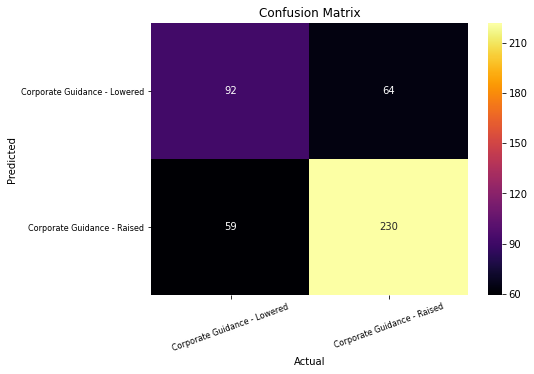

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(num=1, clear=True, figsize=(10,6))
sns.heatmap(cf, ax=ax, annot= True, fmt='d', cmap='inferno', robust=True,
            yticklabels=event_[events], xticklabels=event_[events])
ax.set_title('Confusion Matrix')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.yaxis.set_tick_params(labelsize=8, rotation=0)
ax.xaxis.set_tick_params(labelsize=8, rotation=20)
plt.subplots_adjust(left=0.35, bottom=0.25)
plt.savefig(os.path.join(imgdir, "confusion.jpg"))
plt.show()


## Display top words in wordcloud

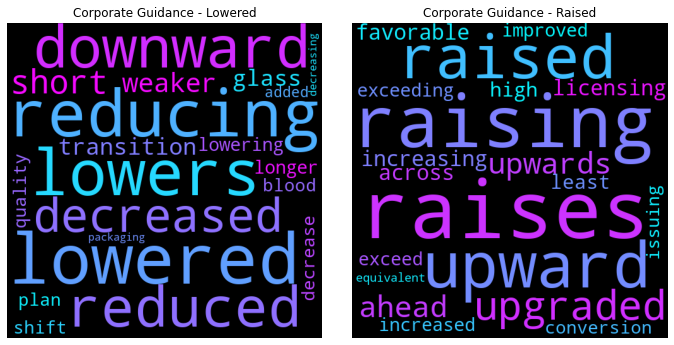

In [19]:
wc = WordCloud(width=500, height=500, stopwords=stop_words, colormap='cool')
top_k = 20
arg_sort = np.argsort(w)
fig, axes = plt.subplots(1, 2, clear=True, num=1, figsize=(10,6))
for ax, args, e in zip(axes, [arg_sort[:top_k], arg_sort[-top_k:]], events):
    words = {idx2word[a]: abs(w[a]) for a in args}   # top words and weights
    ax.imshow(wc.generate_from_frequencies(words))
    ax.axis("off")
    plt.tight_layout(pad=3)
    ax.set_title(event_[e])
plt.savefig(os.path.join(imgdir, "words.jpg"))
plt.show()